# Explanatory Data Analysis: Experiment 00b
analysis of similarity scores of the backbone models for duplicate detection and intra-class and inter-class similarity analysis.

In [5]:
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from jaguar.components import MegaDescriptor
from jaguar.datasets import get_data, get_dataloaders

In [6]:
BASE_CONFIG = {
    "random_seed": 42,
    "data_dir": Path("../../data"),
    "validation_split_size": 0.2,
    "cache_dir": Path("../../cache"),
    "embeddings_dir": Path("../../embeddings")
}
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(BASE_CONFIG["random_seed"])
pd.set_option('display.width', 1000)
np.random.seed(BASE_CONFIG["random_seed"])

In [7]:
train_data, val_data, test_data, num_classes, label_encoder = get_data(
    data_path=BASE_CONFIG["data_dir"], 
    validation_split_size=BASE_CONFIG["validation_split_size"], 
    seed=BASE_CONFIG["random_seed"]
)
display(train_data.head())

,filename,ground_truth,label_encoded
1372,../../data/train/train/train_1373.png,Ousado,20
775,../../data/train/train/train_0776.png,Kwang,15
1094,../../data/train/train/train_1095.png,Marcela,18
1784,../../data/train/train/train_1785.png,Ti,29
112,../../data/train/train/train_0113.png,Benita,6


## Duplicates and Near Duplicates

In [8]:
backbone = MegaDescriptor(freeze=True, cache_folder=BASE_CONFIG["embeddings_dir"])
backbone_name = f"Backbone: {backbone.__class__.__name__}"
base_transforms = backbone.get_transforms()

train_dataloader, validation_dataloader, test_dataloader, num_classes, label_encoder = get_dataloaders(
    data_dir=BASE_CONFIG["data_dir"],
    validation_split_size=BASE_CONFIG["validation_split_size"],
    seed=BASE_CONFIG["random_seed"],
    batch_size=32,
    image_size=256,
    cache_dir=BASE_CONFIG["cache_dir"],
    train_process_fn=base_transforms,
    val_process_fn=base_transforms,
    mode="background",
)

In [9]:
def extract_embeddings(dataloader, model, device):
    model.to(device)
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting embeddings"):
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu())
            labels.extend(targets.numpy())
    embeddings = torch.cat(embeddings)
    return embeddings, np.array(labels)

train_embeddings, train_labels = extract_embeddings(train_dataloader, backbone, device)
val_embeddings, val_labels = extract_embeddings(validation_dataloader, backbone, device)

Extracting embeddings:   0%|          | 0/48 [00:00<?, ?it/s]

Extracting embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
def cosine_similarity_matrix(embeddings):
    norm_embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    similarity_matrix = torch.mm(norm_embeddings, norm_embeddings.t())
    return similarity_matrix

similarity_matrix = cosine_similarity_matrix(train_embeddings)
similarity_matrix -= torch.eye(similarity_matrix.size(0))  # Remove self-similarity
duplicate_pairs = torch.nonzero(similarity_matrix)
most_similar_pairs = duplicate_pairs[similarity_matrix[duplicate_pairs[:, 0], duplicate_pairs[:, 1]].argsort(descending=True)]

similar_df = pd.DataFrame(most_similar_pairs.numpy(), columns=['Index1', 'Index2'])
similar_df['Similarity'] = similarity_matrix[most_similar_pairs[:, 0], most_similar_pairs[:, 1]].numpy()
similar_df = similar_df[similar_df['Index1'] < similar_df['Index2']]  # Avoid duplicate pairs
similar_df['Label1'] = train_labels[similar_df['Index1']]
similar_df['Label2'] = train_labels[similar_df['Index2']]
similar_df['Image1'] = train_data.iloc[similar_df['Index1']]['filename'].values
similar_df['Image2'] = train_data.iloc[similar_df['Index2']]['filename'].values
similar_df['IsMatch'] = similar_df['Label1'] == similar_df['Label2']

print(similar_df)

         Index1  Index2  Similarity  Label1  Label2                                 Image1                                 Image2  IsMatch
0           839    1410    0.999652      30      30  ../../data/train/train/train_1720.png  ../../data/train/train/train_1235.png     True
3          1058    1319    0.999475      30      30  ../../data/train/train/train_1676.png  ../../data/train/train/train_1119.png     True
4           455     543    0.999467      30      30  ../../data/train/train/train_0322.png  ../../data/train/train/train_0025.png     True
7           950    1058    0.999299      30      30  ../../data/train/train/train_1792.png  ../../data/train/train/train_1676.png     True
8            17     642    0.999256      30      30  ../../data/train/train/train_0389.png  ../../data/train/train/train_1579.png     True
...         ...     ...         ...     ...     ...                                    ...                                    ...      ...
2297792     269    1506   -

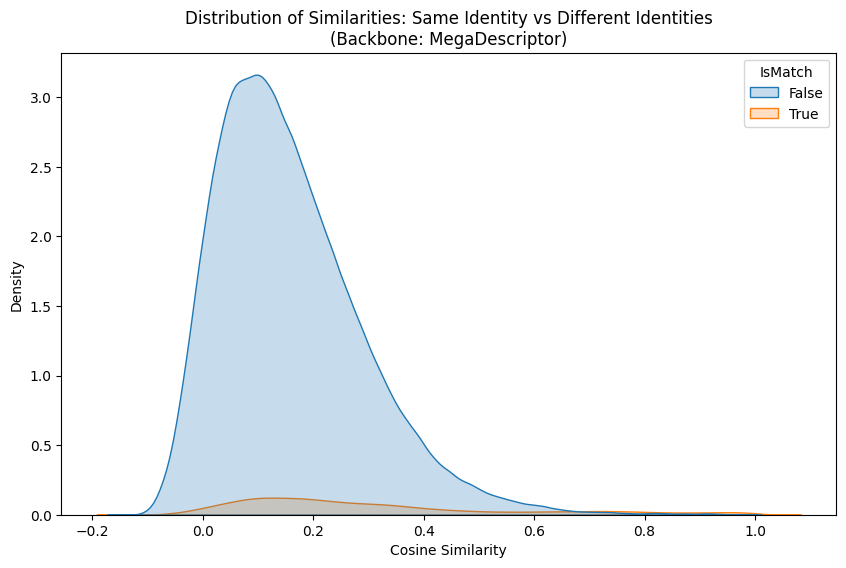

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=similar_df, x='Similarity', hue='IsMatch', fill=True, common_norm=True)
plt.title(f"Distribution of Similarities: Same Identity vs Different Identities\n({backbone_name})")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.show()

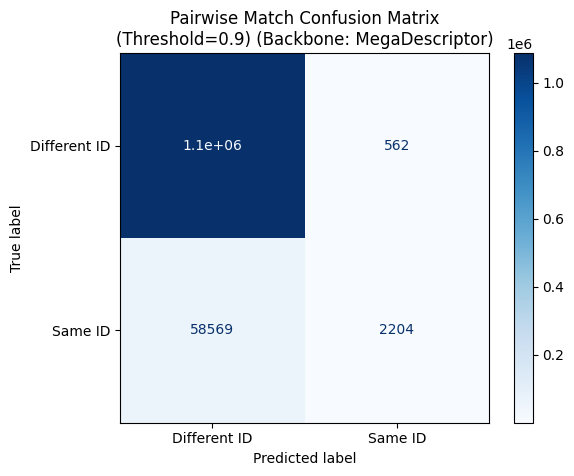

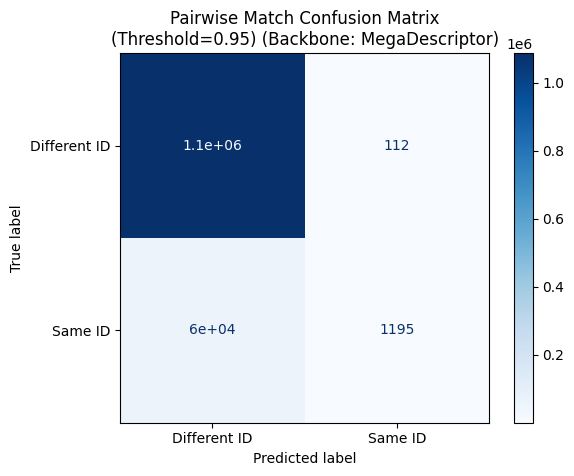

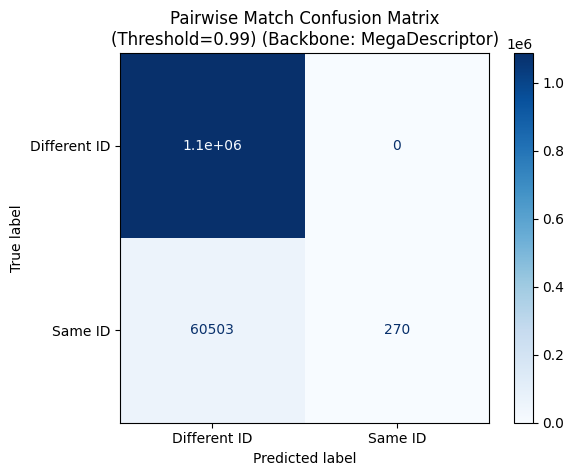

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for threshold in [0.90, 0.95, 0.99]:
    similar_df['Pred_Match'] = similar_df['Similarity'] > threshold

    cm = confusion_matrix(similar_df['IsMatch'], similar_df['Pred_Match'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Different ID', 'Same ID'])
    disp.plot(cmap='Blues')
    plt.title(f"Pairwise Match Confusion Matrix\n(Threshold={threshold}) ({backbone_name})")
plt.show()

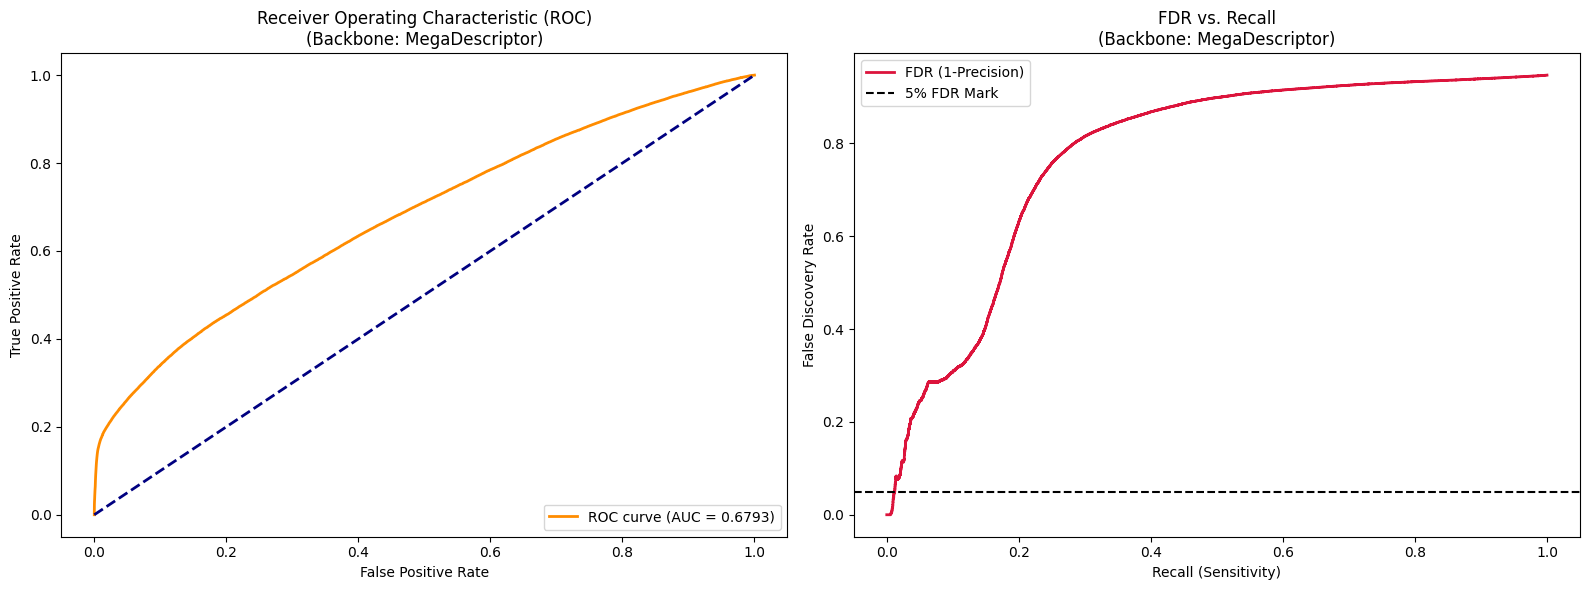

In [13]:
fpr, tpr, thresholds_roc = roc_curve(similar_df['IsMatch'], similar_df['Similarity'])
roc_auc = auc(fpr, tpr)

precision, recall, thresholds_pr = precision_recall_curve(similar_df['IsMatch'], similar_df['Similarity'])
fdr = 1 - precision

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'Receiver Operating Characteristic (ROC)\n({backbone_name})')
ax1.legend(loc="lower right")

ax2.plot(recall, fdr, color='crimson', lw=2, label='FDR (1-Precision)')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('False Discovery Rate')
ax2.set_title(f'FDR vs. Recall\n({backbone_name})')
ax2.axhline(0.05, color='black', linestyle='--', label='5% FDR Mark')
ax2.legend()

plt.tight_layout()
plt.show()

## Intra-Class and Inter-Class Similarity Analysis

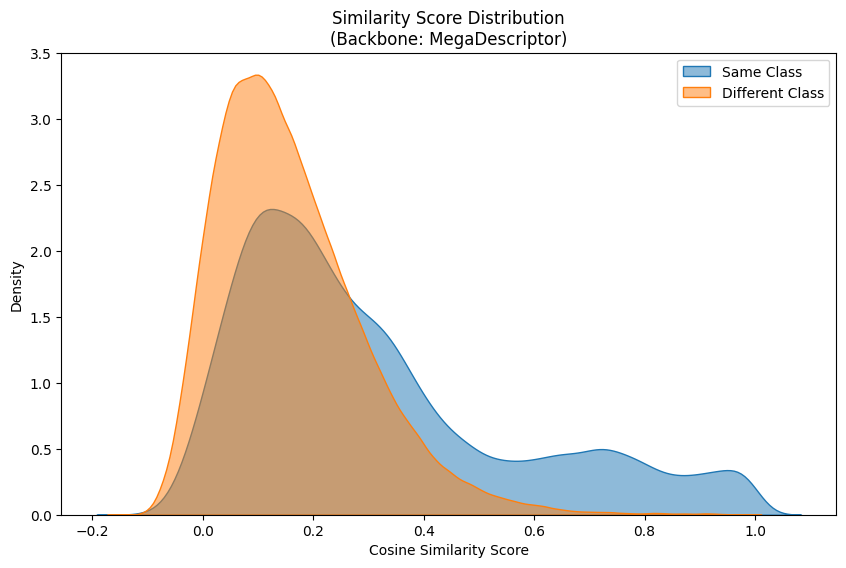

In [18]:
# similarity_matrix
# make a hitogramm for similarity scores for same class and different class
similarity_matrix = cosine_similarity_matrix(train_embeddings)
classes = train_labels
same_class_similarities = []
different_class_similarities = []
num_samples = similarity_matrix.size(0)
for i in tqdm(range(num_samples)):
    for j in range(i + 1, num_samples):
        sim_score = similarity_matrix[i, j].item()
        if classes[i] == classes[j]:
            same_class_similarities.append(sim_score)
        else:
            different_class_similarities.append(sim_score)
plt.figure(figsize=(10, 6))
sns.kdeplot(same_class_similarities, label='Same Class', fill=True, alpha=0.5)
sns.kdeplot(different_class_similarities, label='Different Class', fill=True, alpha=0.5)
plt.title(f'Similarity Score Distribution\n({backbone_name})')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()